### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [ ]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    epochs = 250
    epochs_fine_training = 25
    batch_size = 50
    n_classes = 10

    lambd = 3
    dim_noise = 100
    image_size = (3, 64, 64)

    lr = 0.0002
    beta1 = 0.5

    t_path = "./checkpoint/meta_pseudo_labels(same)/Teacher(ResNet50).pt"
    s_path = "./checkpoint/meta_pseudo_labels(same)/Student(ResNet50).pt"
    s_fine_training_path = "./checkpoint/meta_pseudo_labels(same)/Student_fine_trained(Resnet50).pt"

    history_path = "./history/meta_pseudo_labels(same)/history(ResNet50).csv"
    history_fine_training_path = "./history/meta_pseudo_labels(same)/history_fine_training(ResNet50).csv"

print(Config.device)

cuda


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [ ]:
seed_everything(Config.seed)

### Data Loading

In [ ]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
unlabeled_ds = STL10('./data', split='unlabeled', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


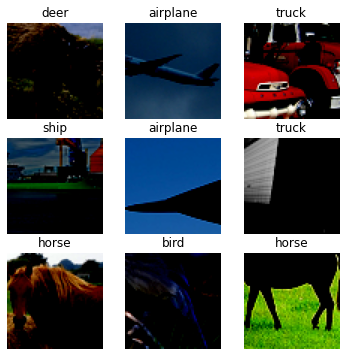

In [ ]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [ ]:
print("labeld size: %d" % (len(train_set)))
print("unlabeld size: %d" % (len(unlabeled_ds)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

labeld size: 4000
unlabeld size: 100000
validation size: 1000
test size: 8000


In [ ]:
labeled_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(train_set), shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride):
        super(ResidualBlock, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        if in_channels != out_channels:
          self.projection = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
          )

        else:
          self.projection = nn.Sequential()

        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        x = self.conv_layers(inputs)
        skip_connection = self.projection(inputs)
        x += skip_connection
        outputs = self.activation(x)
        
        return outputs

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, n_classes):
      super(ResNet50, self).__init__()

      self.conv_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
      )

      self.conv_2 = self.make_block(64, 64, 256, 3, True)
      
      self.conv_3 = self.make_block(256, 128 , 512, 4, True)
      
      self.conv_4 = self.make_block(512, 256, 1024, 6, True)

      self.conv_5 = self.make_block(1024, 512, 2048, 3, True)

      self.avg_pooling = nn.AvgPool2d(kernel_size=4, stride=1)

      self.classifier = nn.Sequential(
          nn.Linear(2048, n_classes),
          nn.Softmax(-1)
      )

      self.initialize_weights()

    def make_block(self, in_channels, mid_channels, out_channels, reps, downsampling):
      outputs = []
      
      if downsampling:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 2))
      
      else:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 1))

      for i in range(reps-1):
        outputs.append(ResidualBlock(out_channels, mid_channels, out_channels, 1))

      return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)
        elif isinstance(i, nn.BatchNorm2d):
            nn.init.normal_(i.weight, mean=1.0, std=0.02)
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.conv_1(inputs)
      x = self.conv_2(x)
      x = self.conv_3(x)
      x = self.conv_4(x)
      x = self.conv_5(x)
      x = self.avg_pooling(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [ ]:
t_model = ResNet50(n_classes=Config.n_classes).to(Config.device)

summary(t_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

In [ ]:
s_model = ResNet50(n_classes=Config.n_classes).to(Config.device)

summary(s_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

### Training Setting

In [ ]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

t_optimizer = optim.Adam(t_model.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))
s_optimizer = optim.Adam(s_model.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))

In [ ]:
def meta_pseudo_labels(t_model, s_model, t_optimizer, s_optimizer, lambd, epochs, t_path, s_path, history_path, labeled_dl, unlabeled_dl, valid_dl):
    history = {'T_loss':[], 'S_loss':[], 'S_valid_acc':[]}        
    start_time = time.time()
    current_label_epoch = 0;
      
    for unlabel_iter in range(int(epochs/len(unlabeled_dl))): 
        for unlabeled_batch, _ in unlabeled_dl:
            epoch_time = time.time()

            total_T_loss = 0
            total_S_loss = 0

            s_model.train()
            for (labeled_inputs, labels), i in tqdm(zip(labeled_dl, range(len(labeled_dl))), total=len(labeled_dl), desc="Training", leave=False):
                labeled_inputs, labels = labeled_inputs.to(Config.device), labels.to(Config.device)
                unlabeled_inputs = unlabeled_batch[i*Config.batch_size:(i+1)*Config.batch_size].to(Config.device)
       
                t_unlabeled_outputs = t_model(unlabeled_inputs)
                _, pseudo_labels = torch.max(t_unlabeled_outputs.detach().data, 1)
                
                # Train s_model
                s_optimizer.zero_grad()

                s_unlabeled_outputs = s_model(unlabeled_inputs)
                s_labeled_outputs_old = s_model(labeled_inputs)

                s_cross_entropy_unlabeled = cross_entropy(s_unlabeled_outputs, pseudo_labels)

                s_loss = s_cross_entropy_unlabeled
                s_loss.backward(retain_graph=True)
                s_optimizer.step()

                total_S_loss += s_loss.item()

                # Train t_model      
                t_optimizer.zero_grad()

                t_labeled_outputs = t_model(labeled_inputs)

                t_cross_entropy_unlabeled = cross_entropy(t_unlabeled_outputs, pseudo_labels)
                t_cross_entropy_labeled = cross_entropy(t_labeled_outputs, labels) 

                s_labeled_outputs_new = s_model(labeled_inputs)
                s_cross_entropy_labeled_old = cross_entropy(s_labeled_outputs_old.detach(), labels)
                s_cross_entropy_labeled_new = cross_entropy(s_labeled_outputs_new.detach(), labels)
                coefficient_from_s = s_cross_entropy_labeled_old - s_cross_entropy_labeled_new

                t_loss = (coefficient_from_s * t_cross_entropy_unlabeled) + (lambd * t_cross_entropy_labeled)
                t_loss.backward(retain_graph=True)
                t_optimizer.step()

                total_T_loss += t_loss.item()

            T_loss = total_T_loss / len(labeled_dl)
            S_loss = total_S_loss / len(labeled_dl)

            history['T_loss'].append(T_loss)
            history['S_loss'].append(S_loss)

            valid_total = 0
            valid_correct = 0

            s_model.eval()
            with torch.no_grad():
              for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
                  inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                  outputs = s_model(inputs)
                  _, predicted = torch.max(outputs.data, 1)

                  valid_total += labels.size(0)
                  valid_correct += (predicted == labels).sum().item()

            valid_acc = valid_correct / valid_total * 100

            history['S_valid_acc'].append(valid_acc)

            torch.save(t_model.state_dict(), t_path)
            torch.save(s_model.state_dict(), s_path)

            current_label_epoch += 1
            tqdm.write('[Epoch : %d/%d] T_loss: %.5f, S_loss: %.5f, S_valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (current_label_epoch, epochs, T_loss, S_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return t_model, s_model, history

In [ ]:
def fine_training(model, optimizer, epochs, model_path, history_path, train_dl, valid_dl):
    history = {'train_loss':[], 'valid_acc':[]}        
    start_time = time.time()
      
    for epoch in range(epochs): 
        epoch_time = time.time()

        train_losses = 0

        valid_total = 0
        valid_correct = 0

        model.train()
        for inputs, labels in tqdm(train_dl, desc="Training", leave=False):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                optimizer.zero_grad()

                outputs = model(inputs)
                cross_entropy_loss = cross_entropy(outputs, labels)

                loss = cross_entropy_loss
                loss.backward(retain_graph=True)
                optimizer.step()

                train_losses += loss.item()

        train_loss = train_losses / len(train_dl)
        history['train_loss'].append(train_loss)

        model.eval()
        with torch.no_grad():
          for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
              inputs, labels = inputs.to(Config.device), labels.to(Config.device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)

              valid_total += labels.size(0)
              valid_correct += (predicted == labels).sum().item()

        valid_acc = valid_correct / valid_total * 100
        history['valid_acc'].append(valid_acc)

        tqdm.write('[Epoch : %d/%d] train_loss: %.5f, valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (epoch + 1, epochs, train_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

        torch.save(model.state_dict(), model_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return model, history

### Meta Pseudo Labels

In [ ]:
t_model, s_model, history = meta_pseudo_labels(t_model, s_model, t_optimizer, s_optimizer, Config.lambd, Config.epochs, Config.t_path, Config.s_path, Config.history_path, labeled_dl, unlabeled_dl, valid_dl)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 1/250] T_loss: 6.78268, S_loss: 2.20186, S_valid_acc: 16.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 2/250] T_loss: 6.69064, S_loss: 1.93930, S_valid_acc: 19.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 3/250] T_loss: 6.67130, S_loss: 1.85880, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 4/250] T_loss: 6.66797, S_loss: 1.86105, S_valid_acc: 17.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 5/250] T_loss: 6.61583, S_loss: 1.92914, S_valid_acc: 21.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 6/250] T_loss: 6.66455, S_loss: 2.10129, S_valid_acc: 16.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 7/250] T_loss: 6.73407, S_loss: 2.04645, S_valid_acc: 18.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 8/250] T_loss: 6.65457, S_loss: 2.05023, S_valid_acc: 15.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 9/250] T_loss: 6.65294, S_loss: 1.98870, S_valid_acc: 18.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 10/250] T_loss: 6.66193, S_loss: 1.89220, S_valid_acc: 20.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 11/250] T_loss: 6.63638, S_loss: 1.97531, S_valid_acc: 18.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 12/250] T_loss: 6.66076, S_loss: 1.99124, S_valid_acc: 18.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 13/250] T_loss: 6.64903, S_loss: 1.94938, S_valid_acc: 18.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 14/250] T_loss: 6.63266, S_loss: 1.99180, S_valid_acc: 18.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 15/250] T_loss: 6.62464, S_loss: 1.96940, S_valid_acc: 20.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 16/250] T_loss: 6.67879, S_loss: 2.05414, S_valid_acc: 19.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 17/250] T_loss: 6.63761, S_loss: 2.13531, S_valid_acc: 17.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 18/250] T_loss: 6.59333, S_loss: 1.94897, S_valid_acc: 20.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 19/250] T_loss: 6.58324, S_loss: 1.95992, S_valid_acc: 20.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 20/250] T_loss: 6.59054, S_loss: 2.03012, S_valid_acc: 19.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 21/250] T_loss: 6.53310, S_loss: 2.06975, S_valid_acc: 19.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 22/250] T_loss: 6.57591, S_loss: 2.12123, S_valid_acc: 18.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 23/250] T_loss: 6.54379, S_loss: 2.08900, S_valid_acc: 20.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 24/250] T_loss: 6.54636, S_loss: 2.01195, S_valid_acc: 20.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 25/250] T_loss: 6.56835, S_loss: 2.12149, S_valid_acc: 19.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 26/250] T_loss: 6.56745, S_loss: 2.05548, S_valid_acc: 19.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 27/250] T_loss: 6.56487, S_loss: 2.01371, S_valid_acc: 18.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 28/250] T_loss: 6.52499, S_loss: 2.07559, S_valid_acc: 19.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 29/250] T_loss: 6.55326, S_loss: 2.10349, S_valid_acc: 19.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 30/250] T_loss: 6.53519, S_loss: 2.13939, S_valid_acc: 20.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 31/250] T_loss: 6.50395, S_loss: 2.09078, S_valid_acc: 21.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 32/250] T_loss: 6.53846, S_loss: 2.09200, S_valid_acc: 20.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 33/250] T_loss: 6.50058, S_loss: 2.07201, S_valid_acc: 20.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 34/250] T_loss: 6.46686, S_loss: 2.04188, S_valid_acc: 19.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 35/250] T_loss: 6.50155, S_loss: 2.11254, S_valid_acc: 21.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 36/250] T_loss: 6.51146, S_loss: 2.10640, S_valid_acc: 20.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 37/250] T_loss: 6.50211, S_loss: 2.17837, S_valid_acc: 18.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 38/250] T_loss: 6.50137, S_loss: 2.14891, S_valid_acc: 19.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 39/250] T_loss: 6.52038, S_loss: 2.13898, S_valid_acc: 19.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 40/250] T_loss: 6.48058, S_loss: 2.11801, S_valid_acc: 20.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 41/250] T_loss: 6.46668, S_loss: 2.08905, S_valid_acc: 19.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 42/250] T_loss: 6.47157, S_loss: 2.03919, S_valid_acc: 19.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 43/250] T_loss: 6.46870, S_loss: 2.05292, S_valid_acc: 20.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 44/250] T_loss: 6.49534, S_loss: 2.11938, S_valid_acc: 20.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 45/250] T_loss: 6.56333, S_loss: 2.16417, S_valid_acc: 18.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 46/250] T_loss: 6.59256, S_loss: 2.11002, S_valid_acc: 19.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 47/250] T_loss: 6.51522, S_loss: 2.01401, S_valid_acc: 19.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 48/250] T_loss: 6.48895, S_loss: 2.06079, S_valid_acc: 21.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 49/250] T_loss: 6.47714, S_loss: 2.02582, S_valid_acc: 19.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 50/250] T_loss: 6.47959, S_loss: 2.08839, S_valid_acc: 20.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 51/250] T_loss: 6.47772, S_loss: 2.10568, S_valid_acc: 19.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 52/250] T_loss: 6.45791, S_loss: 2.04069, S_valid_acc: 21.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 53/250] T_loss: 6.49566, S_loss: 2.01384, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 54/250] T_loss: 6.51861, S_loss: 2.04051, S_valid_acc: 20.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 55/250] T_loss: 6.44394, S_loss: 2.08649, S_valid_acc: 20.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 56/250] T_loss: 6.44915, S_loss: 2.09966, S_valid_acc: 21.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 57/250] T_loss: 6.49068, S_loss: 2.10497, S_valid_acc: 20.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 58/250] T_loss: 6.49051, S_loss: 2.12236, S_valid_acc: 19.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 59/250] T_loss: 6.47337, S_loss: 2.07882, S_valid_acc: 21.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 60/250] T_loss: 6.44988, S_loss: 2.09011, S_valid_acc: 20.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 61/250] T_loss: 6.45785, S_loss: 2.11060, S_valid_acc: 21.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 62/250] T_loss: 6.49358, S_loss: 2.09610, S_valid_acc: 20.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 63/250] T_loss: 6.45458, S_loss: 2.07252, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 64/250] T_loss: 6.44011, S_loss: 2.06618, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 65/250] T_loss: 6.51753, S_loss: 2.13373, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 66/250] T_loss: 6.50086, S_loss: 2.07319, S_valid_acc: 19.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 67/250] T_loss: 6.52539, S_loss: 2.03061, S_valid_acc: 21.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 68/250] T_loss: 6.48140, S_loss: 2.08520, S_valid_acc: 17.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 69/250] T_loss: 6.48180, S_loss: 2.13937, S_valid_acc: 20.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 70/250] T_loss: 6.46732, S_loss: 2.10091, S_valid_acc: 20.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 71/250] T_loss: 6.45413, S_loss: 2.13327, S_valid_acc: 21.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 72/250] T_loss: 6.42636, S_loss: 2.14405, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 73/250] T_loss: 6.40267, S_loss: 2.08309, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 74/250] T_loss: 6.42147, S_loss: 2.07947, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 75/250] T_loss: 6.44309, S_loss: 2.13571, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 76/250] T_loss: 6.40542, S_loss: 2.11312, S_valid_acc: 20.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 77/250] T_loss: 6.45978, S_loss: 2.06839, S_valid_acc: 19.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 78/250] T_loss: 6.43981, S_loss: 2.07838, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 79/250] T_loss: 6.39353, S_loss: 2.01950, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 80/250] T_loss: 6.39802, S_loss: 2.07424, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 81/250] T_loss: 6.40573, S_loss: 2.05732, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 82/250] T_loss: 6.41746, S_loss: 2.08712, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 83/250] T_loss: 6.39591, S_loss: 2.01471, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 84/250] T_loss: 6.40030, S_loss: 2.01007, S_valid_acc: 21.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 85/250] T_loss: 6.40290, S_loss: 2.03333, S_valid_acc: 21.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 86/250] T_loss: 6.37512, S_loss: 2.08433, S_valid_acc: 20.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 87/250] T_loss: 6.38001, S_loss: 2.01407, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 88/250] T_loss: 6.33473, S_loss: 2.05367, S_valid_acc: 21.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 89/250] T_loss: 6.36970, S_loss: 2.11204, S_valid_acc: 22.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 90/250] T_loss: 6.39834, S_loss: 2.11688, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 91/250] T_loss: 6.37228, S_loss: 2.10394, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 92/250] T_loss: 6.34663, S_loss: 2.09382, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 93/250] T_loss: 6.36169, S_loss: 2.07009, S_valid_acc: 21.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 94/250] T_loss: 6.33289, S_loss: 2.09702, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 95/250] T_loss: 6.30984, S_loss: 2.07869, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 96/250] T_loss: 6.28736, S_loss: 2.09763, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 97/250] T_loss: 6.31718, S_loss: 2.06506, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 98/250] T_loss: 6.35920, S_loss: 2.05276, S_valid_acc: 21.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 99/250] T_loss: 6.30090, S_loss: 2.09871, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 100/250] T_loss: 6.33236, S_loss: 2.07002, S_valid_acc: 23.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 101/250] T_loss: 6.37220, S_loss: 2.07266, S_valid_acc: 21.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 102/250] T_loss: 6.32874, S_loss: 2.05296, S_valid_acc: 21.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 103/250] T_loss: 6.30896, S_loss: 2.04812, S_valid_acc: 22.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 104/250] T_loss: 6.30484, S_loss: 2.09190, S_valid_acc: 21.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 105/250] T_loss: 6.28421, S_loss: 2.04417, S_valid_acc: 20.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 106/250] T_loss: 6.32988, S_loss: 2.05302, S_valid_acc: 21.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 107/250] T_loss: 6.30251, S_loss: 2.08825, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 108/250] T_loss: 6.30615, S_loss: 2.11141, S_valid_acc: 21.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 109/250] T_loss: 6.30797, S_loss: 2.09580, S_valid_acc: 22.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 110/250] T_loss: 6.29276, S_loss: 2.09791, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 111/250] T_loss: 6.28377, S_loss: 2.09570, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 112/250] T_loss: 6.26623, S_loss: 2.11270, S_valid_acc: 22.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 113/250] T_loss: 6.28362, S_loss: 2.08588, S_valid_acc: 22.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 114/250] T_loss: 6.26086, S_loss: 2.07145, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 115/250] T_loss: 6.24424, S_loss: 2.05813, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 116/250] T_loss: 6.25332, S_loss: 2.05552, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 117/250] T_loss: 6.22933, S_loss: 2.02186, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 118/250] T_loss: 6.28738, S_loss: 2.01370, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 119/250] T_loss: 6.25646, S_loss: 2.07337, S_valid_acc: 23.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 120/250] T_loss: 6.22037, S_loss: 2.09676, S_valid_acc: 23.50, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 121/250] T_loss: 6.22968, S_loss: 2.06785, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 122/250] T_loss: 6.25209, S_loss: 2.07051, S_valid_acc: 22.40, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 123/250] T_loss: 6.19288, S_loss: 2.09709, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 124/250] T_loss: 6.21708, S_loss: 2.08714, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 125/250] T_loss: 6.21530, S_loss: 2.15750, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 126/250] T_loss: 6.22232, S_loss: 2.14507, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 127/250] T_loss: 6.21621, S_loss: 2.10219, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 128/250] T_loss: 6.19428, S_loss: 2.14206, S_valid_acc: 22.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 129/250] T_loss: 6.17825, S_loss: 2.12042, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 130/250] T_loss: 6.16421, S_loss: 2.09064, S_valid_acc: 21.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 131/250] T_loss: 6.16594, S_loss: 2.07803, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 132/250] T_loss: 6.18818, S_loss: 2.14301, S_valid_acc: 21.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 133/250] T_loss: 6.17363, S_loss: 2.13825, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 134/250] T_loss: 6.19592, S_loss: 2.13439, S_valid_acc: 22.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 135/250] T_loss: 6.12726, S_loss: 2.10118, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 136/250] T_loss: 6.14545, S_loss: 2.11279, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 137/250] T_loss: 6.13850, S_loss: 2.13350, S_valid_acc: 21.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 138/250] T_loss: 6.15811, S_loss: 2.10951, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 139/250] T_loss: 6.13276, S_loss: 2.09994, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 140/250] T_loss: 6.13278, S_loss: 2.13912, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 141/250] T_loss: 6.14073, S_loss: 2.11570, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 142/250] T_loss: 6.11441, S_loss: 2.11642, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 143/250] T_loss: 6.10205, S_loss: 2.10243, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 144/250] T_loss: 6.09442, S_loss: 2.14974, S_valid_acc: 22.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 145/250] T_loss: 6.12226, S_loss: 2.12369, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 146/250] T_loss: 6.12196, S_loss: 2.14946, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 147/250] T_loss: 6.10740, S_loss: 2.12445, S_valid_acc: 23.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 148/250] T_loss: 6.12683, S_loss: 2.09982, S_valid_acc: 22.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 149/250] T_loss: 6.08088, S_loss: 2.15573, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 150/250] T_loss: 6.08816, S_loss: 2.15007, S_valid_acc: 23.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 151/250] T_loss: 6.07017, S_loss: 2.11718, S_valid_acc: 22.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 152/250] T_loss: 6.10474, S_loss: 2.08918, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 153/250] T_loss: 6.05919, S_loss: 2.13070, S_valid_acc: 21.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 154/250] T_loss: 6.09472, S_loss: 2.14644, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 155/250] T_loss: 6.05344, S_loss: 2.18350, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 156/250] T_loss: 6.03520, S_loss: 2.19764, S_valid_acc: 23.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 157/250] T_loss: 6.00235, S_loss: 2.18954, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 158/250] T_loss: 6.02749, S_loss: 2.18090, S_valid_acc: 22.60, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 159/250] T_loss: 6.02298, S_loss: 2.20131, S_valid_acc: 23.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 160/250] T_loss: 5.94800, S_loss: 2.20574, S_valid_acc: 23.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 161/250] T_loss: 5.95961, S_loss: 2.17893, S_valid_acc: 22.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 162/250] T_loss: 5.95963, S_loss: 2.15229, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 163/250] T_loss: 5.96053, S_loss: 2.16567, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 164/250] T_loss: 5.98141, S_loss: 2.14108, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 165/250] T_loss: 5.98058, S_loss: 2.11875, S_valid_acc: 23.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 166/250] T_loss: 5.95104, S_loss: 2.15191, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 167/250] T_loss: 5.92346, S_loss: 2.17366, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 168/250] T_loss: 5.96200, S_loss: 2.16023, S_valid_acc: 21.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 169/250] T_loss: 5.95315, S_loss: 2.15292, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 170/250] T_loss: 5.94837, S_loss: 2.14575, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 171/250] T_loss: 5.94209, S_loss: 2.16613, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 172/250] T_loss: 5.91533, S_loss: 2.19159, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 173/250] T_loss: 5.91261, S_loss: 2.18037, S_valid_acc: 23.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 174/250] T_loss: 5.90625, S_loss: 2.15821, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 175/250] T_loss: 5.89346, S_loss: 2.18531, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 176/250] T_loss: 5.93328, S_loss: 2.18519, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 177/250] T_loss: 5.91773, S_loss: 2.16347, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 178/250] T_loss: 5.92431, S_loss: 2.17450, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 179/250] T_loss: 5.93949, S_loss: 2.18076, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 180/250] T_loss: 5.91614, S_loss: 2.19814, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 181/250] T_loss: 5.92293, S_loss: 2.18287, S_valid_acc: 23.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 182/250] T_loss: 5.90082, S_loss: 2.18267, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 183/250] T_loss: 5.86935, S_loss: 2.18816, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 184/250] T_loss: 5.86671, S_loss: 2.21308, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 185/250] T_loss: 5.84853, S_loss: 2.20566, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 186/250] T_loss: 5.87917, S_loss: 2.18071, S_valid_acc: 23.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 187/250] T_loss: 5.83944, S_loss: 2.17644, S_valid_acc: 23.30, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 188/250] T_loss: 5.85026, S_loss: 2.18807, S_valid_acc: 23.90, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 189/250] T_loss: 5.83280, S_loss: 2.17601, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 190/250] T_loss: 5.86708, S_loss: 2.17578, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 191/250] T_loss: 5.82691, S_loss: 2.18037, S_valid_acc: 22.40, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 192/250] T_loss: 5.85383, S_loss: 2.15460, S_valid_acc: 24.30, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 193/250] T_loss: 5.87014, S_loss: 2.18465, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 194/250] T_loss: 5.86879, S_loss: 2.19722, S_valid_acc: 23.60, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 195/250] T_loss: 5.83802, S_loss: 2.21258, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 196/250] T_loss: 5.84423, S_loss: 2.20265, S_valid_acc: 22.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 197/250] T_loss: 5.84862, S_loss: 2.17076, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 198/250] T_loss: 5.80937, S_loss: 2.17162, S_valid_acc: 23.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 199/250] T_loss: 5.83929, S_loss: 2.17643, S_valid_acc: 23.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 200/250] T_loss: 5.80680, S_loss: 2.20710, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 201/250] T_loss: 5.82077, S_loss: 2.19599, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 202/250] T_loss: 5.81557, S_loss: 2.19960, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 203/250] T_loss: 5.79286, S_loss: 2.15654, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 204/250] T_loss: 5.76741, S_loss: 2.20341, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 205/250] T_loss: 5.74921, S_loss: 2.17680, S_valid_acc: 22.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 206/250] T_loss: 5.80589, S_loss: 2.17519, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 207/250] T_loss: 5.81407, S_loss: 2.16445, S_valid_acc: 22.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 208/250] T_loss: 5.81047, S_loss: 2.21072, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 209/250] T_loss: 5.80704, S_loss: 2.16683, S_valid_acc: 23.80, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 210/250] T_loss: 5.81288, S_loss: 2.15698, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 211/250] T_loss: 5.79763, S_loss: 2.19058, S_valid_acc: 23.40, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 212/250] T_loss: 5.78437, S_loss: 2.16684, S_valid_acc: 24.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 213/250] T_loss: 5.72109, S_loss: 2.18998, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 214/250] T_loss: 5.76278, S_loss: 2.19845, S_valid_acc: 23.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 215/250] T_loss: 5.72173, S_loss: 2.18804, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 216/250] T_loss: 5.72101, S_loss: 2.19497, S_valid_acc: 23.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 217/250] T_loss: 5.70948, S_loss: 2.17999, S_valid_acc: 24.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 218/250] T_loss: 5.72074, S_loss: 2.20543, S_valid_acc: 22.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 219/250] T_loss: 5.71459, S_loss: 2.20601, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 220/250] T_loss: 5.70933, S_loss: 2.18167, S_valid_acc: 24.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 221/250] T_loss: 5.66683, S_loss: 2.18252, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 222/250] T_loss: 5.72226, S_loss: 2.20257, S_valid_acc: 24.30, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 223/250] T_loss: 5.65086, S_loss: 2.19427, S_valid_acc: 22.80, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 224/250] T_loss: 5.64782, S_loss: 2.19687, S_valid_acc: 24.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 225/250] T_loss: 5.66594, S_loss: 2.18674, S_valid_acc: 23.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 226/250] T_loss: 5.64670, S_loss: 2.18227, S_valid_acc: 23.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 227/250] T_loss: 5.64026, S_loss: 2.19451, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 228/250] T_loss: 5.64197, S_loss: 2.21131, S_valid_acc: 23.80, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 229/250] T_loss: 5.67642, S_loss: 2.20044, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 230/250] T_loss: 5.61644, S_loss: 2.19343, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 231/250] T_loss: 5.57572, S_loss: 2.19831, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 232/250] T_loss: 5.61153, S_loss: 2.19046, S_valid_acc: 24.00, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 233/250] T_loss: 5.62403, S_loss: 2.19148, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 234/250] T_loss: 5.59663, S_loss: 2.20038, S_valid_acc: 24.30, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 235/250] T_loss: 5.55763, S_loss: 2.18436, S_valid_acc: 24.80, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 236/250] T_loss: 5.59157, S_loss: 2.19565, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 237/250] T_loss: 5.58265, S_loss: 2.21275, S_valid_acc: 24.30, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 238/250] T_loss: 5.58967, S_loss: 2.16717, S_valid_acc: 25.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 239/250] T_loss: 5.56825, S_loss: 2.17596, S_valid_acc: 24.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 240/250] T_loss: 5.57349, S_loss: 2.20394, S_valid_acc: 23.20, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 241/250] T_loss: 5.53488, S_loss: 2.17792, S_valid_acc: 24.50, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 242/250] T_loss: 5.53982, S_loss: 2.20638, S_valid_acc: 22.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 243/250] T_loss: 5.55217, S_loss: 2.17639, S_valid_acc: 25.10, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 244/250] T_loss: 5.53244, S_loss: 2.17244, S_valid_acc: 24.10, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 245/250] T_loss: 5.54884, S_loss: 2.20141, S_valid_acc: 24.20, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 246/250] T_loss: 5.54524, S_loss: 2.18481, S_valid_acc: 24.80, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 247/250] T_loss: 5.54714, S_loss: 2.19849, S_valid_acc: 24.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 248/250] T_loss: 5.52934, S_loss: 2.18889, S_valid_acc: 24.90, elapsed_time_in_epoch: 00:33


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 249/250] T_loss: 5.55061, S_loss: 2.16434, S_valid_acc: 23.70, elapsed_time_in_epoch: 00:32


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 250/250] T_loss: 5.54529, S_loss: 2.17461, S_valid_acc: 23.60, elapsed_time_in_epoch: 00:32
Finished training
Total elapsed time: 144:30


### Fine Training

In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

<All keys matched successfully>

In [ ]:
model, history = fine_training(s_model, s_optimizer, Config.epochs_fine_training, Config.s_fine_training_path, Config.history_fine_training_path, labeled_dl, valid_dl)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 1/25] train_loss: 2.20086, valid_acc: 24.40, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 2/25] train_loss: 2.19134, valid_acc: 25.50, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 3/25] train_loss: 2.19317, valid_acc: 22.90, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 4/25] train_loss: 2.19098, valid_acc: 23.90, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 5/25] train_loss: 2.18891, valid_acc: 26.10, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 6/25] train_loss: 2.18193, valid_acc: 26.60, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 7/25] train_loss: 2.18310, valid_acc: 26.40, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 8/25] train_loss: 2.17696, valid_acc: 27.10, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 9/25] train_loss: 2.18155, valid_acc: 26.30, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 10/25] train_loss: 2.18102, valid_acc: 25.40, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 11/25] train_loss: 2.17802, valid_acc: 26.70, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 12/25] train_loss: 2.17207, valid_acc: 27.70, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 13/25] train_loss: 2.16994, valid_acc: 26.70, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 14/25] train_loss: 2.17477, valid_acc: 26.30, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 15/25] train_loss: 2.17566, valid_acc: 26.50, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 16/25] train_loss: 2.17132, valid_acc: 27.20, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 17/25] train_loss: 2.17317, valid_acc: 25.60, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 18/25] train_loss: 2.16604, valid_acc: 25.90, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 19/25] train_loss: 2.16475, valid_acc: 27.90, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 20/25] train_loss: 2.17229, valid_acc: 26.40, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 21/25] train_loss: 2.17039, valid_acc: 25.60, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 22/25] train_loss: 2.16885, valid_acc: 26.90, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 23/25] train_loss: 2.16679, valid_acc: 27.40, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 24/25] train_loss: 2.16450, valid_acc: 28.10, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 25/25] train_loss: 2.16594, valid_acc: 26.20, elapsed_time_in_epoch: 00:11
Finished training
Total elapsed time: 05:07


### Testing

In [ ]:
t_model.load_state_dict(torch.load(Config.t_path))

test_total = 0
test_correct = 0

t_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("t_model test_acc: %.5f" %(test_acc))

t_model test_acc: 55.80000


In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model test_acc: %.5f" %(test_acc))

s_model test_acc: 25.53750


In [ ]:
s_model.load_state_dict(torch.load(Config.s_fine_training_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model_fine_trained test_acc: %.5f" %(test_acc))

s_model_fine_trained test_acc: 28.47500
